## Imports and GPU usage

In [5]:
import numpy as np
import random
import sys
import os
from torch.utils.data import Dataset, DataLoader, ConcatDataset, random_split
import glob
import cv2
import torch
from torch import nn
import torchvision
from torchvision import transforms
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix, accuracy_score
from torchinfo import summary
import torch.optim as optim
from tqdm import tqdm

In [6]:
# Use GPU if have
device = 'cuda' if torch.cuda.is_available() else 'cpu'
print(device)

cuda


## Preprocess and Data seperation

In [7]:
# Dirs
tumor_dir = './resources/brainTumorDataset/Tumor/*'
healthy_dir = './resources/brainTumorDataset/Healthy/*'

In [8]:
# Put everything into an np array
tumorArr = []
healthyArr = []

for x in glob.iglob(tumor_dir):
    img = cv2.imread(x)
    img = cv2.resize(img, (224, 224)) # size based on original paper
    b, g, r = cv2.split(img)
    img = cv2.merge([r, g, b])
    tumorArr.append(img)
    
for x in glob.iglob(healthy_dir):
    img = cv2.imread(x)
    img = cv2.resize(img, (224, 224))
    b, g, r = cv2.split(img)
    img = cv2.merge([r, g, b])
    healthyArr.append(img)
    
tumorArr = np.array(tumorArr)
healthyArr = np.array(healthyArr)
tumorNHealthyArr = np.concatenate((tumorArr, healthyArr))

In [9]:
# Check arrs
print(tumorArr.shape)
print(healthyArr.shape)
print(tumorNHealthyArr.shape)

(2512, 224, 224, 3)
(2086, 224, 224, 3)
(4598, 224, 224, 3)


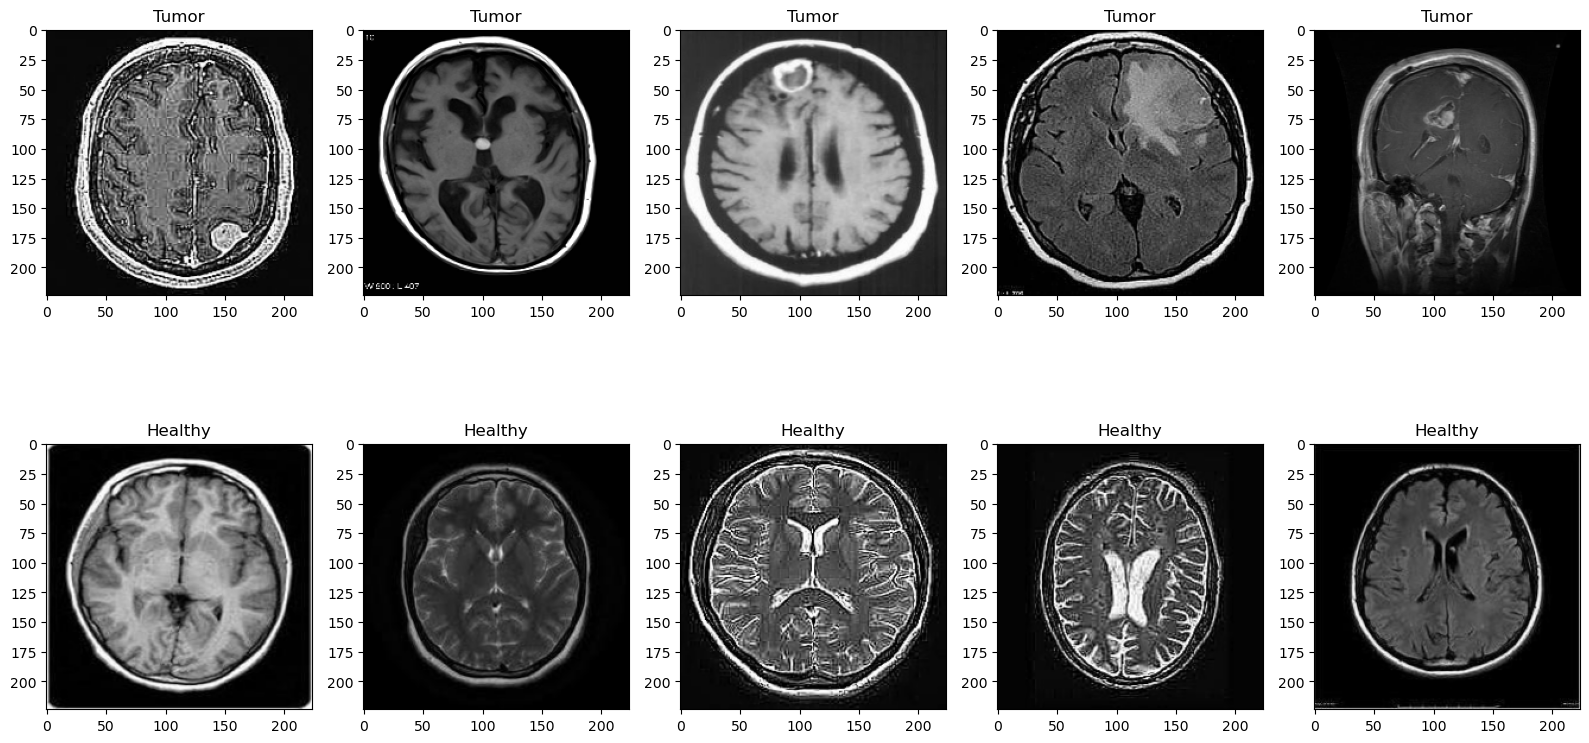

In [10]:
# Checking a couple imgs in the array
checkNum = 5

# Choose random images from the arrays
tumorRanIndices = np.random.choice(tumorArr.shape[0], checkNum, replace=False)
healthyRanIndices = np.random.choice(healthyArr.shape[0], checkNum, replace=False)
tumorRanImgs = tumorArr[tumorRanIndices]
healthyRanImgs = healthyArr[healthyRanIndices]

plt.figure(figsize=(16, 9))

for i in range(checkNum):
    plt.subplot(2, checkNum, i + 1)
    plt.title('Tumor')
    plt.imshow(tumorRanImgs[i])

for i in range(checkNum):
    plt.subplot(2, checkNum, checkNum + i + 1)
    plt.title('Healthy')
    plt.imshow(healthyRanImgs[i])

plt.tight_layout()
plt.show()

In [11]:
# Pytorch dataset class
class Dataset(Dataset):
    def __init__(self, data, labels, transform = None):
        self.data = data
        self.labels = labels
        self.transform = transform
        
    def __len__(self):
        return len(self.data)

    def __getitem__(self, idx):
        item = {'data': self.data[idx], 'label': self.labels[idx]}

        if self.transform:
            item = self.transform(item)

        return item
    
    def normalize(self):
        self.data = self.data/255.0


In [12]:
# Gotta modify a little bit before putting it into the dataset
modifiedTumorArr = []
modifiedHealthyArr = []

# Change shape into channels, height, width for the pytorch dataset
for x in tumorArr:
    x = x.reshape((img.shape[2], img.shape[0], img.shape[1]))
    modifiedTumorArr.append(x)
    
for x in healthyArr:
    x = x.reshape((img.shape[2], img.shape[0], img.shape[1]))
    modifiedHealthyArr.append(x)
    
modifiedTumorArr = np.array(modifiedTumorArr, dtype = np.float32)
modifiedHealthyArr = np.array(modifiedHealthyArr, dtype = np.float32)

# print(modifiedTumorArr.shape)
# print(modifiedHealthyArr.shape)


# Labels
tumorLabels = np.ones(modifiedTumorArr.shape[0], dtype = np.float32)
healthyLabels = np.zeros(modifiedHealthyArr.shape[0], dtype = np.float32)

# Concats
dataConcat = np.concatenate((modifiedTumorArr, modifiedHealthyArr), axis = 0)
labelsConcat = np.concatenate((tumorLabels, healthyLabels))

# Actual pytorch dataset class
brainTumorDataset = Dataset(dataConcat, labelsConcat)
brainTumorDataset.normalize()
brainTumorDataset.__len__()

4598

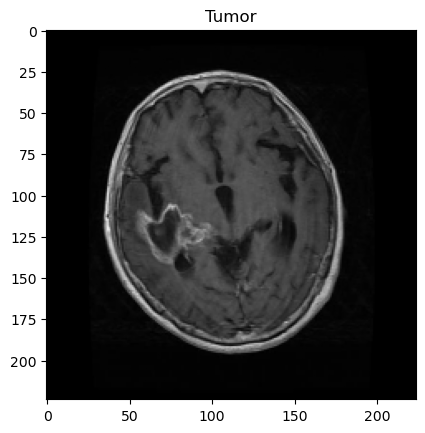

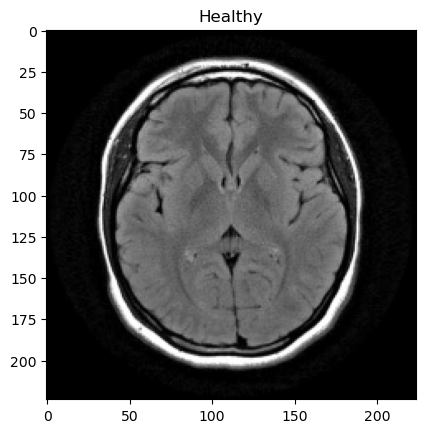

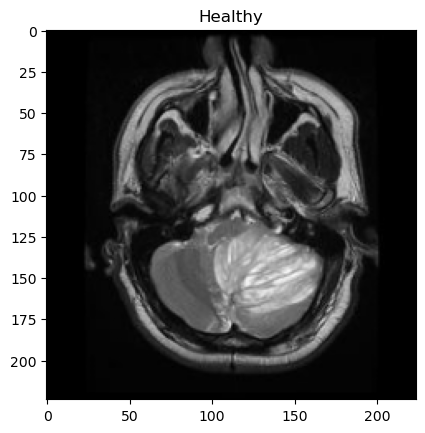

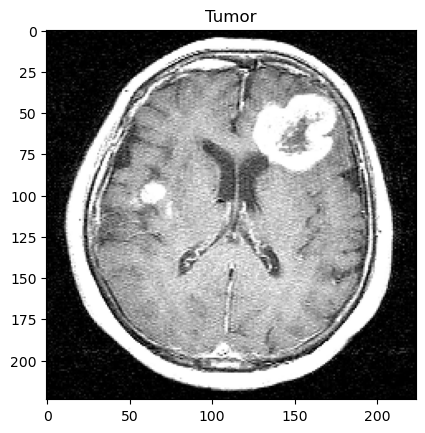

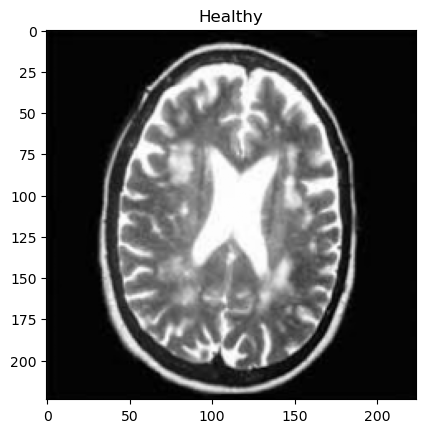

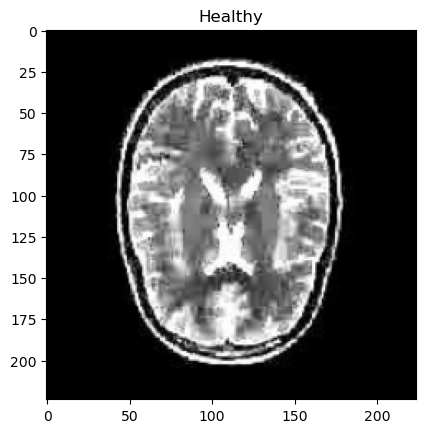

In [13]:
# Check dataset by iterating
dataloader = DataLoader(brainTumorDataset, shuffle = True)

labelEx = {0: 'Healthy', 1: 'Tumor'}

for i, item in enumerate(dataloader):
    img = item['data'].squeeze()
    img = img.reshape((img.shape[1], img.shape[2], img.shape[0]))
    plt.title(labelEx[item['label'].item()])
    plt.imshow(img)
    plt.show()
    if i == 5:
        break

In [14]:
# Split datasets
trainSize = int(0.8 * len(brainTumorDataset))
testSize = len(brainTumorDataset) - trainSize

trainDataset, testDataset = random_split(brainTumorDataset, [trainSize, testSize])

trainLoader = DataLoader(trainDataset, batch_size=1, shuffle=True)
testLoader = DataLoader(testDataset, batch_size=1, shuffle=False)

# VIT from scratch
This part of the notebook will be a Vision Transformer made from scratch. Later on, we will see that the training and eval accuracy will not be so good.
<br/>
In the next part of the notebook, a pretrained Vision Transformer will be used to increase the accuracy.

## Patch embedding class

note: every hyperparameter below will be based on the original vision transformer paper (https://arxiv.org/pdf/2010.11929v2.pdf)

In [15]:
class PatchPositionClassEmbedding(nn.Module):
    def __init__(self,
                 inChannels: int = 3,
                 patchSize: int = 16,
                 embeddingDim: int = 768):
        super().__init__()
        
        self.patchSize = patchSize
        self.embeddingDim = embeddingDim
        
        # We can use a convolution layer to turn images into patches
        self.patcher = nn.Conv2d(in_channels=inChannels,
                                 out_channels=embeddingDim,
                                 kernel_size=patchSize,
                                 stride=patchSize,
                                 padding=0)
        
        # We then flatten everything into a single vector
        self.flatten = nn.Flatten(start_dim=2, end_dim=3)
        
        # Class token
        self.classToken = nn.Parameter(data=torch.randn(1, 1, embeddingDim), requires_grad=True)
        
        # Position embedding
        self.positionEmbedding = nn.Parameter(data=torch.randn(1, 197, embeddingDim),
                                              requires_grad=True)

    def forward(self, img):
        # Handle error when image is not divisible by patch size.
        # 224/16 = 14, so should be okay
        imageRes = img.shape[-1]
        assert imageRes % self.patchSize == 0, f"Image size is not divisible by patch size"
        
        imgPatched = self.patcher(img)
        imgFlattened = self.flatten(imgPatched)
        
        imgFlattened = imgFlattened.permute(0, 2, 1)  # batch size, num of patches, size of each patch   
        
        # Expand class token and position embedding to match batch size
        batchSize = imgFlattened.shape[0]
        classToken = self.classToken.expand(batchSize, -1, -1)
        positionEmbedding = self.positionEmbedding.expand(batchSize, -1, -1)
        
        # Concatenate tensors
        patchEmbeddedAndClassToken = torch.cat((classToken, imgFlattened), dim=1)
        
        # Add position embedding
        patchPositionClass = patchEmbeddedAndClassToken + positionEmbedding
        
        return patchPositionClass


In [16]:
# Check if it works or not
singleImage = modifiedTumorArr[0]

singleImageTensor = torch.from_numpy(singleImage).unsqueeze(0)

print(f"Input image shape: {singleImageTensor.shape}")

patchPosClassFunc = PatchPositionClassEmbedding()

# Pass the image tensor through the PatchEmbedding module
finalResult = patchPosClassFunc(singleImageTensor)
print(f"Output embedded vector shape: {finalResult.shape}")

Input image shape: torch.Size([1, 3, 224, 224])
Output embedded vector shape: torch.Size([1, 197, 768])


## MSA block and MLP block

note: every hyperparameter below will be based on the original vision transformer paper (https://arxiv.org/pdf/2010.11929v2.pdf)

In [17]:
class MSABlock(nn.Module):
    def __init__(self,
                embeddingDim: int = 768,
                numHeads: int = 12,
                attnDropout: float = 0):
        super().__init__()
        
        self.layerNorm = nn.LayerNorm(normalized_shape = embeddingDim)
        
        self.multiheadAttn = nn.MultiheadAttention(embed_dim = embeddingDim,
                                                   num_heads = numHeads,
                                                   dropout = attnDropout,
                                                   batch_first = True)
        
    def forward(self, x):
        x = self.layerNorm(x)
        attnOutput, _ = self.multiheadAttn(query = x,
                                           key = x,
                                           value = x,
                                           need_weights = False)
        return attnOutput

In [18]:
class MLPBlock(nn.Module):
    def __init__(self,
                embeddingDim: int = 768,
                mlpSize: int = 3072,
                dropout: float = 0.1):
        super().__init__()
        
        self.layerNorm = nn.LayerNorm(normalized_shape = embeddingDim)
        
        self.mlp = nn.Sequential(
            nn.Linear(in_features = embeddingDim,
                     out_features = mlpSize),
            nn.GELU(),
            nn.Dropout(p = dropout),
            nn.Linear(in_features = mlpSize, out_features = embeddingDim),
            nn.Dropout(p = dropout)
        )
    
    def forward(self, x):
        x = self.layerNorm(x)
        x = self.mlp(x)
        return x

## Transformer encoder (combine MSA & MLP)

In [19]:
class TEBlock(nn.Module):
    def __init__(self,
                embeddingDim: int = 768,
                numHeads: int = 12,
                mlpSize: int = 3072,
                mlpDropout: float = 0.1,
                attnDropout: float = 0):
        super().__init__()
        
        self.MSABlock = MSABlock(embeddingDim = embeddingDim,
                                numHeads = numHeads,
                                attnDropout = attnDropout)
        
        self.MLPBlock = MLPBlock(embeddingDim = embeddingDim,
                                mlpSize = mlpSize,
                                dropout = mlpDropout)
        
    def forward(self, x):

        # Residual connections
        x = self.MSABlock(x) + x
        x = self.MLPBlock(x) + x

        return x

In [20]:
# Check out if it works or not
transformerEncoderBlock = TEBlock()

summary(model = transformerEncoderBlock,
        input_size = (1, 197, 768),
        col_names = ["input_size", "output_size", "num_params", "trainable"],
        col_width = 20,
       row_settings = ["var_names"])

Layer (type (var_name))                       Input Shape          Output Shape         Param #              Trainable
TEBlock (TEBlock)                             [1, 197, 768]        [1, 197, 768]        --                   True
├─MSABlock (MSABlock)                         [1, 197, 768]        [1, 197, 768]        --                   True
│    └─LayerNorm (layerNorm)                  [1, 197, 768]        [1, 197, 768]        1,536                True
│    └─MultiheadAttention (multiheadAttn)     --                   [1, 197, 768]        2,362,368            True
├─MLPBlock (MLPBlock)                         [1, 197, 768]        [1, 197, 768]        --                   True
│    └─LayerNorm (layerNorm)                  [1, 197, 768]        [1, 197, 768]        1,536                True
│    └─Sequential (mlp)                       [1, 197, 768]        [1, 197, 768]        --                   True
│    │    └─Linear (0)                        [1, 197, 768]        [1, 197, 3072]  

## ViT (combine everything)

note: every hyperparameter below will be based on the original vision transformer paper (https://arxiv.org/pdf/2010.11929v2.pdf)

In [21]:
class VIT(nn.Module):
    def __init__(self,
                imgSize: int = 224,
                inChannels: int = 3,
                patchSize: int = 16,
                numTransformerLayers: int = 12,
                embeddingDim: int = 768,
                mlpSize: int = 3072,
                numHeads: int = 12,
                attnDropout: float = 0,
                mlpDropout: float = 0.1,
                embeddingDropout: float = 0.1,
                numClasses: int = 2):
        super().__init__()
        
        self.embeddingDropout = nn.Dropout(p = embeddingDropout)
        
        self.patchPosClassEmb = PatchPositionClassEmbedding(inChannels = inChannels,
                                            patchSize = patchSize,
                                            embeddingDim = embeddingDim)
        
        # We'll stack encoder blocks.
        self.transformerEncoder = nn.Sequential(*[TEBlock(
            embeddingDim = embeddingDim,
            numHeads = numHeads,
            mlpSize = mlpSize,
            mlpDropout = mlpDropout) for _ in range (numTransformerLayers)])
        
        self.classifier = nn.Sequential(
            nn.LayerNorm(normalized_shape = embeddingDim),
            nn.Linear(in_features = embeddingDim,
                     out_features = numClasses))
        
    def forward(self, x):
        x = self.patchPosClassEmb(x)
        x = self.embeddingDropout(x)
        x = self.transformerEncoder(x)
        x = self.classifier(x[:, 0])
        return x

In [22]:
# Full detail of the model
vit = VIT()
# vit.eval()

## Training and Evaluation

note: every hyperparameter below will be based on the original vision transformer paper (https://arxiv.org/pdf/2010.11929v2.pdf)

In [36]:
lossFunc = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(params=vit.parameters(),
                             lr=3e-3,
                             betas=(0.9, 0.999),
                             weight_decay=0.3)

# Training loop
numEpochs = 10
device = torch.device("cuda")

vit.to(device)

trainLosses = []
trainAccuracies = []
testLosses = []
testAccuracies = []

for epoch in range(numEpochs):
    vit.train()
    totalLoss = 0.0
    correctTrain = 0
    totalTrain = 0
    
    for batch in tqdm(trainLoader, desc=f"Epoch {epoch+1}/{numEpochs}", leave=False):
        images, labels = batch['data'].to(device), batch['label'].to(device)
        
        optimizer.zero_grad()
        outputs = vit(images)
        loss = lossFunc(outputs, labels.long())
        loss.backward()
        optimizer.step()
        
        totalLoss += loss.item() * images.size(0)
        
        _, predictedTrain = torch.max(outputs, 1)
        totalTrain += labels.size(0)
        correctTrain += (predictedTrain == labels).sum().item()
    
    epochLoss = totalLoss / len(trainLoader.dataset)
    trainAccuracy = correctTrain / totalTrain
    trainLosses.append(epochLoss)
    trainAccuracies.append(trainAccuracy)
    print(f"Epoch {epoch+1}/{numEpochs}, Training Loss: {epochLoss:.4f}, Training Accuracy: {trainAccuracy:.2%}")

    # Evaluation loop
    vit.eval()
    correct = 0
    total = 0
    testLoss = 0

    with torch.no_grad():
        for batch in tqdm(testLoader, desc="Evaluating", leave=False):
            images, labels = batch['data'].to(device), batch['label'].to(device)
            outputs = vit(images)

            loss = lossFunc(outputs, labels.long())
            testLoss += loss.item() * images.size(0)

            _, predicted = torch.max(outputs, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()

    testAccuracy = correct / total
    testLosses.append(testLoss / len(testLoader.dataset))
    testAccuracies.append(testAccuracy)
    print(f"Epoch {epoch+1}/{numEpochs}, Test Loss: {testLoss:.4f}, Test Accuracy: {testAccuracy:.2%}")

Epoch 1/10, Training Loss: 0.7906, Training Accuracy: 60.98%


Epoch 1/10, Test Loss: 1165.4138, Test Accuracy: 58.59%


Epoch 2/10, Training Loss: 0.7959, Training Accuracy: 61.80%


Epoch 2/10, Test Loss: 628.1503, Test Accuracy: 65.33%


Epoch 3/10, Training Loss: 0.7902, Training Accuracy: 60.11%


Epoch 3/10, Test Loss: 1082.6196, Test Accuracy: 59.57%


Epoch 4/10, Training Loss: 0.8315, Training Accuracy: 61.09%


Epoch 4/10, Test Loss: 684.5593, Test Accuracy: 55.00%


Epoch 5/10, Training Loss: 0.7797, Training Accuracy: 61.72%


Epoch 5/10, Test Loss: 558.3994, Test Accuracy: 67.83%


Epoch 6/10, Training Loss: 0.8058, Training Accuracy: 62.04%


Epoch 6/10, Test Loss: 773.1610, Test Accuracy: 55.54%


Epoch 7/10, Training Loss: 0.8093, Training Accuracy: 60.66%


Epoch 7/10, Test Loss: 589.7659, Test Accuracy: 67.50%


Epoch 8/10, Training Loss: 0.7967, Training Accuracy: 61.26%


Epoch 8/10, Test Loss: 663.3612, Test Accuracy: 60.98%


Epoch 9/10, Training Loss: 0.7884, Training Accuracy: 61.26%


Epoch 9/10, Test Loss: 632.1819, Test Accuracy: 63.37%


Epoch 10/10, Training Loss: 0.7846, Training Accuracy: 60.88%


Epoch 10/10, Test Loss: 576.3304, Test Accuracy: 66.20%


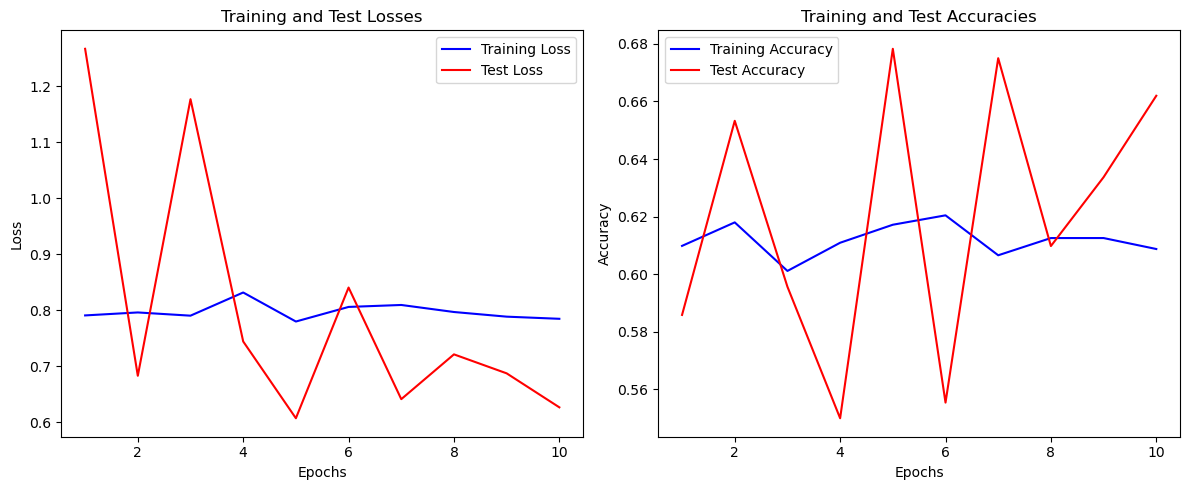

In [37]:
# Plotting
epochs = range(1, numEpochs + 1)

plt.figure(figsize=(12, 5))
plt.subplot(1, 2, 1)
plt.plot(epochs, trainLosses, 'b-', label='Training Loss')
plt.plot(epochs, testLosses, 'r-', label='Test Loss')
plt.title('Training and Test Losses')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(epochs, trainAccuracies, 'b-', label='Training Accuracy')
plt.plot(epochs, testAccuracies, 'r-', label='Test Accuracy')
plt.title('Training and Test Accuracies')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()

plt.tight_layout()
plt.show()

As we can see, the training loss and accuracy does not decrease, and the test loss and accuracy is all over the place. There may be a variety of reasons for this such as: Unfit model architecture, Poor hyperparameter choices, Poor data quality, Unaugmented data, etc. With that being said, let's try using a pretrained VIT, and see whether accuracy increases or not.

# Using a Pretrained ViT

In [24]:
# Getting the pretrained weights
pretrainedVitWeights = torchvision.models.ViT_B_16_Weights.DEFAULT
pretrainedVit = torchvision.models.vit_b_16(weights = pretrainedVitWeights).to(device)

# We freeze the pretrained parameters
for parameter in pretrainedVit.parameters():
    parameter.requires_grad = False
    
classNames = ["Tumor", "Healthy"]

# This is the only layer we will be training on, the only weights we will update.
pretrainedVit.heads = nn.Linear(in_features = 768,
                               out_features = len(classNames)).to(device)
# print(pretrainedVit)

In [25]:
summary(model=pretrainedVit, 
        input_size=(1, 3, 224, 224),
        col_names=["input_size", "output_size", "num_params", "trainable"],
        col_width=20,
        row_settings=["var_names"]
)

Layer (type (var_name))                                      Input Shape          Output Shape         Param #              Trainable
VisionTransformer (VisionTransformer)                        [1, 3, 224, 224]     [1, 2]               768                  Partial
├─Conv2d (conv_proj)                                         [1, 3, 224, 224]     [1, 768, 14, 14]     (590,592)            False
├─Encoder (encoder)                                          [1, 197, 768]        [1, 197, 768]        151,296              False
│    └─Dropout (dropout)                                     [1, 197, 768]        [1, 197, 768]        --                   --
│    └─Sequential (layers)                                   [1, 197, 768]        [1, 197, 768]        --                   False
│    │    └─EncoderBlock (encoder_layer_0)                   [1, 197, 768]        [1, 197, 768]        (7,087,872)          False
│    │    └─EncoderBlock (encoder_layer_1)                   [1, 197, 768]        [1, 1

In [26]:
# We need to transform our data to fit the pretrained Vit
pretrainedVitTransform = pretrainedVitWeights.transforms()
print(pretrainedVitTransform)

ImageClassification(
    crop_size=[224]
    resize_size=[256]
    mean=[0.485, 0.456, 0.406]
    std=[0.229, 0.224, 0.225]
    interpolation=InterpolationMode.BILINEAR
)


In [27]:
trainDataset.transform = pretrainedVitTransform
testDataset.transform = pretrainedVitTransform

trainLoaderTransformed = DataLoader(trainDataset, batch_size=1, shuffle=True)
testLoaderTransformed = DataLoader(testDataset, batch_size=1, shuffle=False)

In [28]:
lossFunc = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(params=pretrainedVit.parameters(),
                             lr=1e-3)

vit = pretrainedVit

lossFunc = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(params=pretrainedVit.parameters(), lr=1e-3)

numEpochs = 10
device = torch.device("cuda")

vit.to(device)

trainLosses = []
trainAccuracies = []
testLosses = []
testAccuracies = []

for epoch in range(numEpochs):
    
    # Training Loop
    vit.train()
    totalLoss = 0.0
    correctTrain = 0
    totalTrain = 0
    
    for batch in tqdm(trainLoaderTransformed, desc=f"Epoch {epoch+1}/{numEpochs}", leave=False):
        images, labels = batch['data'].to(device), batch['label'].to(device)
        
        optimizer.zero_grad()
        outputs = vit(images)
        loss = lossFunc(outputs, labels.long())
        loss.backward()
        optimizer.step()
        
        totalLoss += loss.item() * images.size(0)
        
        _, predictedTrain = torch.max(outputs, 1)
        totalTrain += labels.size(0)
        correctTrain += (predictedTrain == labels).sum().item()
    
    epochLoss = totalLoss / len(trainLoaderTransformed.dataset)
    trainAccuracy = correctTrain / totalTrain
    
    trainLosses.append(epochLoss)
    trainAccuracies.append(trainAccuracy)
    
    print(f"Epoch {epoch+1}/{numEpochs}, Training Loss: {epochLoss:.4f}, Training Accuracy: {trainAccuracy:.2%}")

    # Evaluation loop
    vit.eval()
    correctTest = 0
    totalTest = 0
    testLoss = 0.0

    with torch.no_grad():
        for batch in tqdm(testLoaderTransformed, desc="Evaluating", leave=False):
            images, labels = batch['data'].to(device), batch['label'].to(device)
            outputs = vit(images)
            loss = lossFunc(outputs, labels.long())
            testLoss += loss.item() * images.size(0)
            
            _, predictedTest = torch.max(outputs, 1)
            totalTest += labels.size(0)
            correctTest += (predictedTest == labels).sum().item()

    testAccuracy = correctTest / totalTest
    testLoss = testLoss / len(testLoaderTransformed.dataset)
    
    testLosses.append(testLoss)
    testAccuracies.append(testAccuracy)
    
    print(f"Epoch {epoch+1}/{numEpochs}, Test Loss: {testLoss:.4f}, Test Accuracy: {testAccuracy:.2%}")

Epoch 1/10, Training Loss: 0.5782, Training Accuracy: 70.07%


Epoch 1/10, Test Loss: 0.6071, Test Accuracy: 68.80%


Epoch 2/10, Training Loss: 0.4912, Training Accuracy: 76.48%


Epoch 2/10, Test Loss: 0.4684, Test Accuracy: 76.85%


Epoch 3/10, Training Loss: 0.4521, Training Accuracy: 79.12%


Epoch 3/10, Test Loss: 0.4271, Test Accuracy: 79.78%


Epoch 4/10, Training Loss: 0.4357, Training Accuracy: 80.42%


Epoch 4/10, Test Loss: 0.4231, Test Accuracy: 81.30%


Epoch 5/10, Training Loss: 0.4082, Training Accuracy: 81.59%


Epoch 5/10, Test Loss: 0.4979, Test Accuracy: 75.33%


Epoch 6/10, Training Loss: 0.3972, Training Accuracy: 82.41%


Epoch 6/10, Test Loss: 0.4375, Test Accuracy: 81.20%


Epoch 7/10, Training Loss: 0.3744, Training Accuracy: 83.80%


Epoch 7/10, Test Loss: 0.5274, Test Accuracy: 77.28%


Epoch 8/10, Training Loss: 0.3636, Training Accuracy: 84.45%


Epoch 8/10, Test Loss: 0.3858, Test Accuracy: 82.61%


Epoch 9/10, Training Loss: 0.3502, Training Accuracy: 84.88%


Epoch 9/10, Test Loss: 0.3966, Test Accuracy: 82.39%


Epoch 10/10, Training Loss: 0.3459, Training Accuracy: 84.88%


Epoch 10/10, Test Loss: 0.4393, Test Accuracy: 80.98%


As we can see here, the results are really good. Let's see this in a plot.

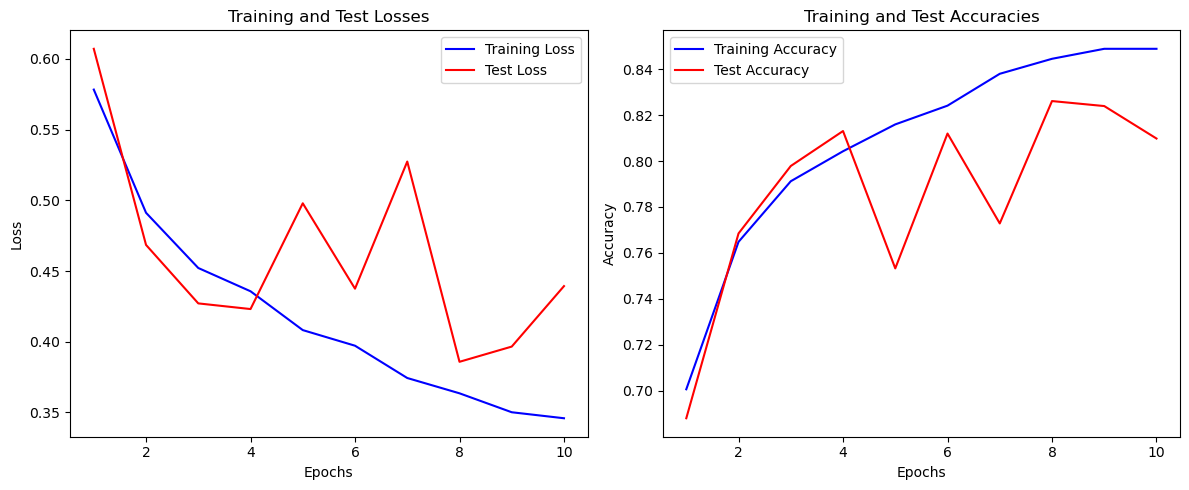

In [29]:
epochs = range(1, numEpochs + 1)

plt.figure(figsize=(12, 5))
plt.subplot(1, 2, 1)
plt.plot(epochs, trainLosses, 'b-', label='Training Loss')
plt.plot(epochs, testLosses, 'r-', label='Test Loss')
plt.title('Training and Test Losses')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(epochs, trainAccuracies, 'b-', label='Training Accuracy')
plt.plot(epochs, testAccuracies, 'r-', label='Test Accuracy')
plt.title('Training and Test Accuracies')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()

plt.tight_layout()
plt.show()

We can see much better results here, with a decreasing loss and increasing accuracy on both training and test cases. Albeit it's not perfect (perhaps some overfitting because of the wobbly test accuracy), training with a pretrained model is much better than training the model from scratch. Perhaps, we can improve the performance of this model by tuning the hyperparameters, increasing epochs, and/or increasing the amount of data we have.

## Single Predictions
Let's see how they do with single predictions

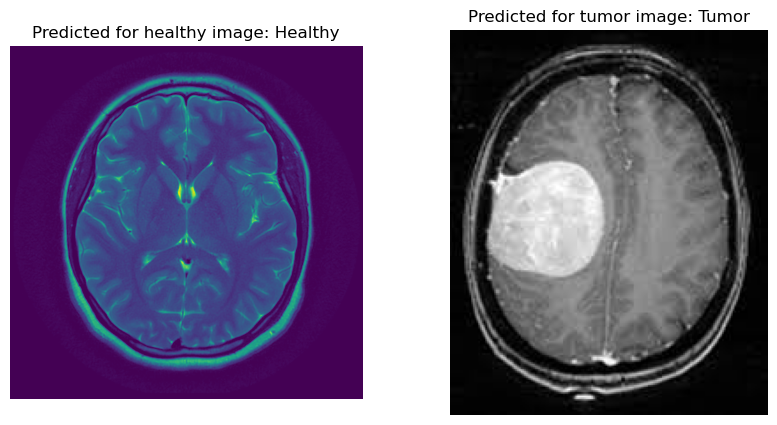

In [47]:
from PIL import Image

healthyImagePath = './resources/singlePredictions/Healthy.jpeg'
tumorImagePath = './resources/singlePredictions/Tumor.jpg'

pretrainedVitTransformSI = transforms.Compose([
    transforms.Resize(256),
    transforms.CenterCrop(224),
    transforms.Grayscale(num_output_channels = 3),
    transforms.ToTensor(),
    transforms.Normalize(mean = [0.485, 0.456, 0.406], std = [0.229, 0.224, 0.225])
])

healthyImage = Image.open(healthyImagePath)
tumorImage = Image.open(tumorImagePath)

transformedHealthyImage = pretrainedVitTransformSI(healthyImage)
transformedTumorImage = pretrainedVitTransformSI(tumorImage)

transformedHealthyImage = transformedHealthyImage.unsqueeze(0).to(device)
transformedTumorImage = transformedTumorImage.unsqueeze(0).to(device)

vit.eval()
with torch.no_grad():
    outputHealthy = vit(transformedHealthyImage)
    outputTumor = vit(transformedTumorImage)
    
classLabels = ["Tumor", "Healthy"]

predictedClassIndexHealthy = torch.argmax(outputHealthy, dim=1).item()
predictedClassLabelHealthy = classLabels[predictedClassIndexHealthy]

predictedClassIndexTumor = torch.argmax(outputTumor, dim=1).item()
predictedClassLabelTumor = classLabels[predictedClassIndexTumor]

# Plot the images
fig, axes = plt.subplots(1, 2, figsize=(10, 5))

axes[0].imshow(healthyImage)
axes[0].set_title(f"Predicted for healthy image: {predictedClassLabelHealthy}")

axes[1].imshow(tumorImage)
axes[1].set_title(f"Predicted for tumor image: {predictedClassLabelTumor}")

for ax in axes:
    ax.axis('off')

plt.show()